In [1]:
# This notebook is a no-frills demonstration of the
# technique of approximating the solid angle of each 
# sample on a sphere. The "right" answer is found from a
# the area of the region on a spherical Voronoi diagram
# that contains that sample. But building such diagrams
# is expensive. We approximate that area by the area of
# a circle, built from the spherical distances to several
# of the sample's nearest neighbors.
# Andrew Glassner, June 2018## Note: Due to matplotlib limitations in 3D, rendered figures
# may contain artifacts and errors. Sigh.

In [2]:
%matplotlib notebook

from matplotlib import colors
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
from scipy.spatial import SphericalVoronoi
from mpl_toolkits.mplot3d import proj3d
import numpy as np 
import math

In [3]:
def make_uniform_points(num_pts=20, seed=42):
    np.random.seed(seed)
    point_list = []
    for _ in range(num_pts):
        v = np.random.uniform(-1, 1, 3)
        vlen = np.linalg.norm(v)
        if vlen > 0:
            v /= vlen
        point_list.append(v)
    return np.array(point_list)

In [4]:
def make_sv(points):
    radius = 1
    center = [0,0,0]
    # calculate spherical Voronoi diagram
    sv = SphericalVoronoi(points, radius, center)
    # sort vertices to be cw in each region
    sv.sort_vertices_of_regions()
    return sv

In [5]:
def get_triangle_area(a, b, c):
    # Neat formulas are for 2D, so use cross product
    area2 = np.linalg.norm(np.cross(b-a, c-a))
    return abs(area2/2)

In [6]:
# https://en.wikipedia.org/wiki/Great-circle_distance
# We use their unusual names and measuring conventions for spherical coords
def spherical_distance(a, b):
    # Assuming sphere radius is 1
    # get spherical coords of a,b
    lambda_a = math.atan2(a[0], a[2])
    d_a = math.sqrt((a[0]*a[0])+(a[2]*a[2]))
    phi_a = math.atan2(a[1], d_a)
    lambda_b = math.atan2(b[0], b[2])
    d_b = math.sqrt((b[0]*b[0])+(b[2]*b[2]))
    phi_b = math.atan2(b[1], d_b)
    # get deltas
    delta_phi = phi_a-phi_b
    delta_lambda = lambda_a-lambda_b
    # apply haversine formula
    f = math.sin(delta_phi/2)**2
    g = math.sin(delta_lambda/2)**2
    g *= math.cos(phi_a) * math.cos(phi_b)
    disc = f+g
    if disc<0:
        print("********* spherical distance: points are somehow wrong")
    else:
        disc = math.sqrt(disc)
    delta_sigma = 2 * math.asin(disc)
    return delta_sigma

In [7]:
def draw_sv(points, sv, draw_bg_sphere=False, draw_voronoi_verts=False, draw_points=False):
    # generate plot
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    if draw_bg_sphere:  # plot the unit sphere for reference 
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        x = np.outer(np.cos(u), np.sin(v))
        y = np.outer(np.sin(u), np.sin(v))
        z = np.outer(np.ones(np.size(u)), np.cos(v))
        ax.plot_surface(x, y, z, color='y', alpha=0.1)
    if draw_voronoi_verts: # plot input points
        ax.scatter(sv.vertices[:, 0], sv.vertices[:, 1], sv.vertices[:, 2], s=80, c='g')
    # draw Voronoi regions (as Euclidean polygons)
    for region in sv.regions:
      random_color = colors.rgb2hex(np.random.rand(3))
      polygon = Poly3DCollection([sv.vertices[region]], alpha=1.0)
      polygon.set_color(random_color)
      ax.add_collection3d(polygon)
    # Get rid of the ticks
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_zticks([])
    if draw_points:
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=80, c='b')
    flat_points = np.ndarray.flatten(points)
    min_val = np.min(flat_points)
    max_val = np.max(flat_points)
    min_limit = min_val - (.1 * (max_val-min_val))
    max_limit = max_val + (.1 * (max_val-min_val))
    ax.set_xlim3d(min_limit, max_limit)
    ax.set_ylim3d(min_limit, max_limit)
    ax.set_zlim3d(min_limit, max_limit)
    plt.show()

In [8]:
num_pts = 200
points = make_uniform_points(num_pts, 42)
sv = make_sv(points)

<IPython.core.display.Javascript object>


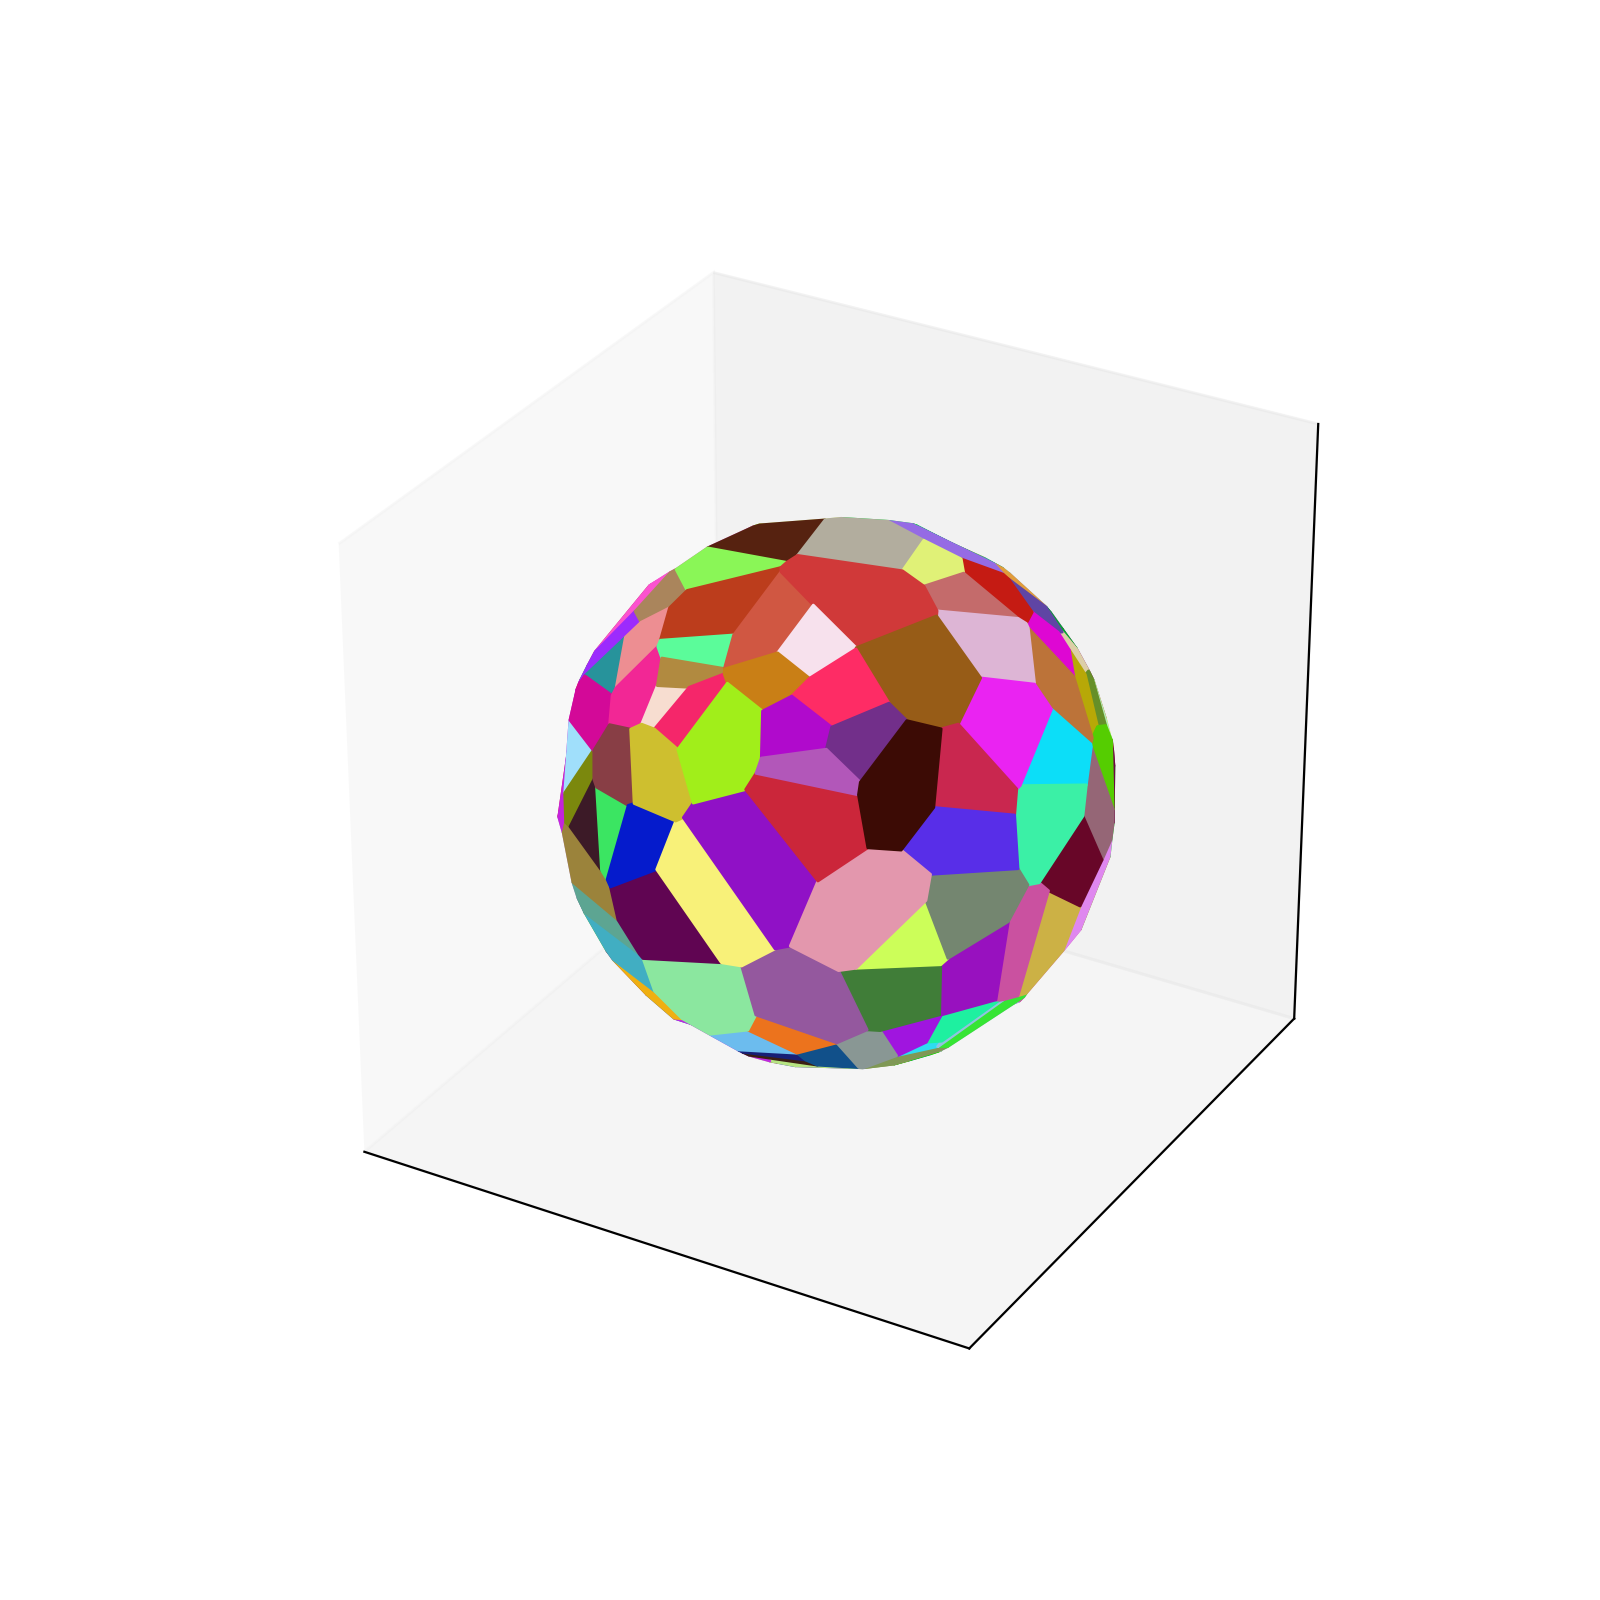

In [9]:
draw_sv(points, sv)

In [10]:
def get_region_stats(sv, num_neighbors):
    region_stats = []
    total_circle_area = 0
    for region_number, region in enumerate(sv.regions):
        num_verts = len(region)
        center = [0, 0, 0]
        for vertex_index in region:
            center += sv.vertices[vertex_index]
        center /= num_verts
        region_area = 0
        average_radius = 0
        for vertex_index in range(len(region)):
            vi0 = vertex_index
            vi1 = (vertex_index+1) % num_verts
            v0 = sv.vertices[region[vi0]]
            v1 = sv.vertices[region[vi1]]
            area = get_triangle_area(center, v0, v1)
            region_area += area
            average_radius += np.linalg.norm(sv.vertices[region[vi0]]-center)
        average_radius /= num_verts
        
        focus_point = sv.vertices[region_number]
        sorted_neighbors = []
        for check_point_number in range(len(points)):
            check_point = sv.vertices[check_point_number]        
            if check_point_number == region_number:
                continue 
            distance = spherical_distance(focus_point, check_point)
            sorted_neighbors.append([check_point_number, distance])
        sorted_neighbors = sorted(sorted_neighbors, key=lambda nd: nd[1])
        
        nearest_neighbors = (num_neighbors * sorted_neighbors)[:num_neighbors]
        avg_of_nearest_distances = sum(n[1] for n in nearest_neighbors)/num_neighbors
        circle_radius = math.sqrt(avg_of_nearest_distances)
        circle_area = np.pi * circle_radius * circle_radius
        total_circle_area += circle_area
        
        region_stats.append({
            'center': center,
            'area': region_area,
            'average_radius': average_radius,
            'circle_radius': circle_radius,
            'circle_area': circle_area,
            'sorted_neighbors': sorted_neighbors,
        })
    normalization_factor = 4*np.pi/total_circle_area
    for stat in region_stats:
        stat['circle_area'] *= normalization_factor
        stat['circle_radius'] = math.sqrt(stat['circle_area']/np.pi)
    return region_stats

In [11]:
# quick sanity check on voronoi and circle areas
stats = get_region_stats(sv, 10)

sphere_surface_area = 4*np.pi
total_region_area = sum([s['area'] for s in stats])
total_circle_area = sum([s['circle_area'] for s in stats])

print("total_region_area = ",total_region_area," sphere area =",sphere_surface_area, "total circle_area=",total_circle_area)

total_region_area =  12.36571836806242  sphere area = 12.566370614359172 total circle_area= 12.566370614359167


In [12]:
def get_circles_error(sv, stats):
    abs_error = 0 # absolute error
    rms_error = 0
    for region_number in range(len(sv.regions)):
        circle_area = stats[region_number]['circle_area']
        region_area = stats[region_number]['area']
        error = abs(circle_area - region_area) 
        abs_error += error
        rms_error += error**2
    rms_error = math.sqrt(rms_error/len(sv.regions))
    return rms_error

In [13]:
def show_circle_errors(min_neighbors, max_neighbors):
    num_neighbors_list = np.array(list(range(min_neighbors, max_neighbors)))
    total_errors = []
    for nn in num_neighbors_list:
        stats = get_region_stats(sv, nn)
        error = get_circles_error(sv, stats)
        total_errors.append(error)
        print(nn,' neighbors, error = ',error)
    fig = plt.figure()
    plt.plot(num_neighbors_list, total_errors)
    plt.title('Total RMS error by number of neighbors',fontsize=14)
    plt.xlabel('number of neighbors',fontsize=14)
    plt.ylabel('RMS error', fontsize=14)
    plt.show()

1  neighbors, error =  0.060517621987011716
2  neighbors, error =  0.048472227158988815
3  neighbors, error =  0.042641663307094416
4  neighbors, error =  0.03979189495404644
5  neighbors, error =  0.03821611850645672
6  neighbors, error =  0.03716508533298241
7  neighbors, error =  0.03649761318321135
8  neighbors, error =  0.03599761735402821
9  neighbors, error =  0.03564468473510634
10  neighbors, error =  0.03543872625683005
11  neighbors, error =  0.035290166524224856
12  neighbors, error =  0.035187326810193195
13  neighbors, error =  0.03510256901098872
14  neighbors, error =  0.03502408932422849
15  neighbors, error =  0.03494381746795231
16  neighbors, error =  0.034883012635582765
17  neighbors, error =  0.03481924586204986
18  neighbors, error =  0.0347456209992731
19  neighbors, error =  0.03466652571175238
20  neighbors, error =  0.034573017638856056
21  neighbors, error =  0.03447772069632372
22  neighbors, error =  0.03439412724249795
23  neighbors, error =  0.034296305

<IPython.core.display.Javascript object>


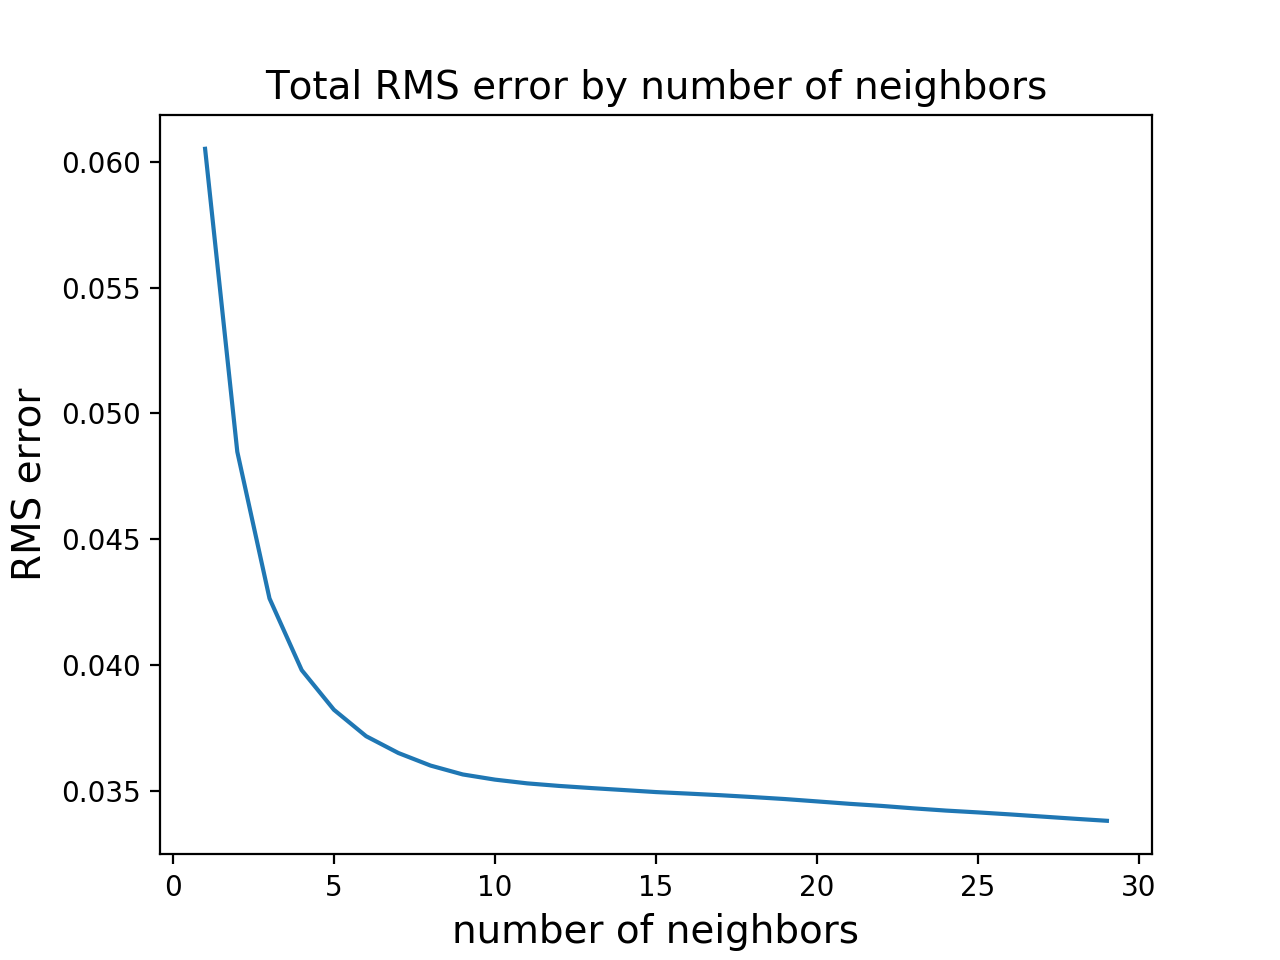

In [14]:
show_circle_errors(1,30)

In [15]:
def draw_circles_sv(sv, stats, draw_bg_sphere=False, circle_sides=10, 
                    radius_scale=1, density=1, circle_alpha=1, region_alpha=1):
    # generate plot
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    if draw_bg_sphere:  # plot the unit sphere for reference 
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        x = np.outer(np.cos(u), np.sin(v))
        y = np.outer(np.sin(u), np.sin(v))
        z = np.outer(np.ones(np.size(u)), np.cos(v))
        ax.plot_surface(x, y, z, color='y', alpha=0.1)
        
    include_region = len(sv.regions) * [True]
    for i in range(len(sv.regions)):
        include_region[i] = np.random.uniform(0,1)<density
    
    # draw Voronoi regions as circles
    if circle_alpha>0:
        for region_number, region in enumerate(sv.regions):
            if not include_region[region_number]:
                continue
            circle_points = []
            random_color = colors.rgb2hex(np.random.rand(3))
            #create a set regular polygon in the plane of the region
            p0 = sv.vertices[region[0]]
            p1 = sv.vertices[region[1]]
            center = stats[region_number]['center']
            v_0_center = [p0[i]-center[i] for i in [0,1,2]]
            v_1_0 = [p1[i]-p0[i] for i in [0,1,2]]
            normal = np.cross(v_0_center, v_1_0)
            base_1 = np.copy(v_0_center)
            base_2 = np.cross(base_1, normal)
            normal /= np.linalg.norm(normal)
            base_1 /= np.linalg.norm(base_1)
            base_2 /= np.linalg.norm(base_2)
            r = stats[region_number]['circle_radius']
            for theta in np.linspace(0, 2*np.pi, circle_sides):
                p0 = normal * 0.05 # push outward a little to avoid z-fighting
                p1 = base_1 * radius_scale * r * math.cos(theta)
                p2 = base_2 * radius_scale * r * math.sin(theta)
                xyz = [p0[i]+p1[i]+p2[i]+center[i] for i in [0,1,2]]
                circle_points.append(xyz)
            polygon = Poly3DCollection([circle_points], alpha=circle_alpha)
            polygon.set_color(random_color)
            polygon.set_edgecolor(3*[1-circle_alpha])
            ax.add_collection3d(polygon)
        
    if region_alpha>0:
        for region_number, region in enumerate(sv.regions):
            if not include_region[region_number]:
                continue
            random_color = colors.rgb2hex(np.random.rand(3))
            polygon = Poly3DCollection([sv.vertices[region]], alpha=region_alpha)
            polygon.set_color(random_color)
            polygon.set_edgecolor(3*[1-region_alpha])
            ax.add_collection3d(polygon)

    # Get rid of the ticks
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_zticks([])
    flat_points = np.ndarray.flatten(points)
    min_val = np.min(flat_points)
    max_val = np.max(flat_points)
    min_limit = min_val - (.1 * (max_val-min_val))
    max_limit = max_val + (.1 * (max_val-min_val))
    ax.set_xlim3d(min_limit, max_limit)
    ax.set_ylim3d(min_limit, max_limit)
    ax.set_zlim3d(min_limit, max_limit)
    plt.show()

<IPython.core.display.Javascript object>


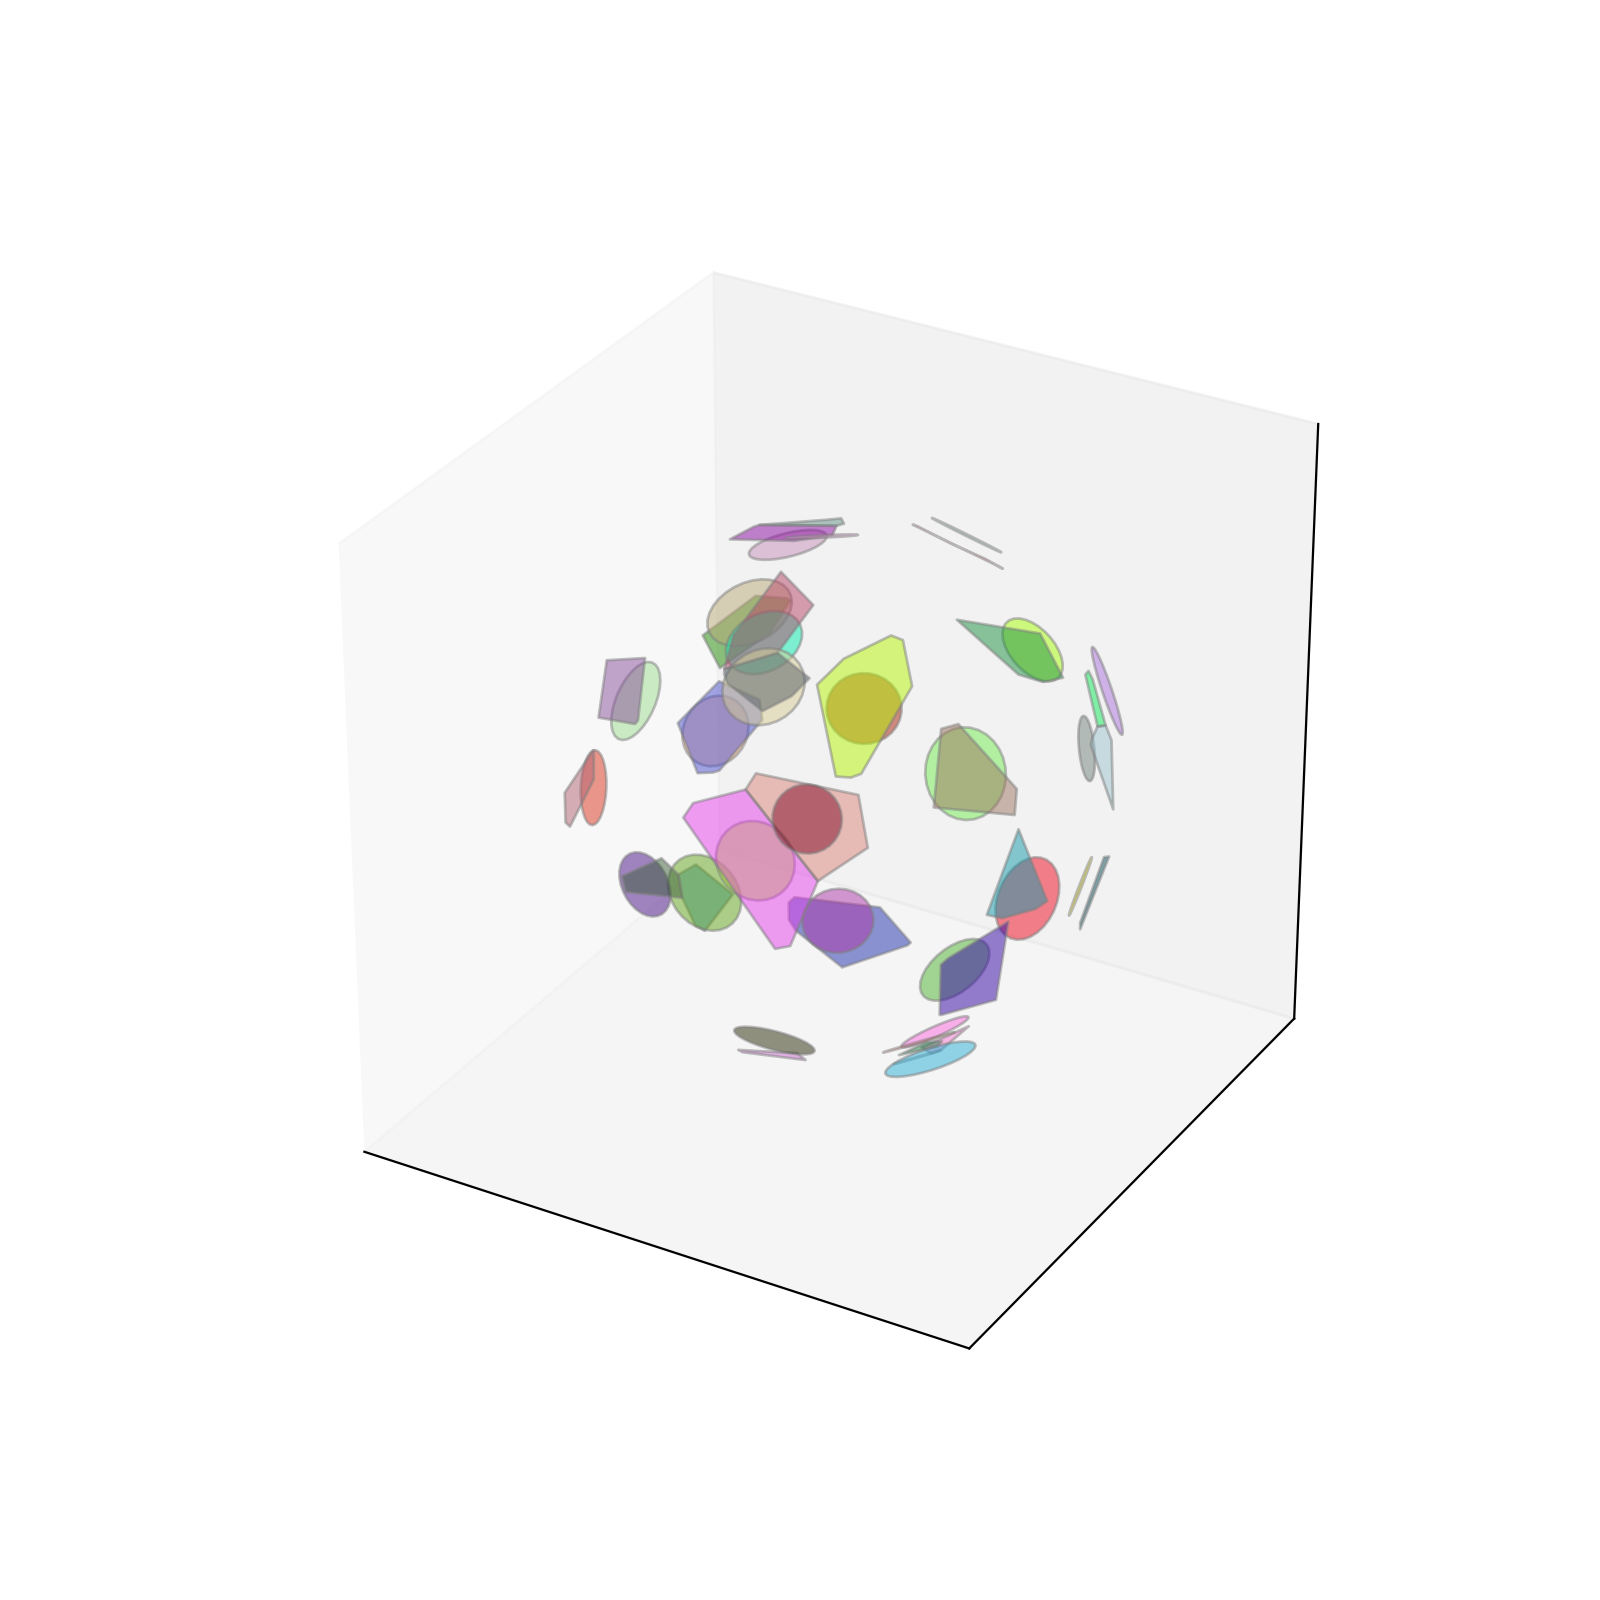

In [16]:
stats = get_region_stats(sv, num_neighbors=10)
draw_circles_sv(sv, stats, circle_sides=30, radius_scale=1, density=0.13, circle_alpha=.5, region_alpha=.5)